# Network analysis: Exercise solutions

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: Learn how to load, process, analyse, and save a-spatial and spatial network data using Python packages.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [1]:
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
assert os.environ['CONDA_DEFAULT_ENV'] == 'geoprogv1'
# spatial libraries 
import fiona as fi
import geopandas
import pandas as pd
import pysal as sal
import geoplot
import numpy as np
import matplotlib.pyplot as plt
import osmnx
import networkx as nx
from networkx import NetworkXError

# create output folder
if not os.path.exists('tmp'):
    os.makedirs('tmp')

print('env ok')

Conda env: geoprogv1
env ok


-----
## Exercises

When you are in doubt about how a package or a function work, use the Python website (https://docs.python.org/3.9/) and **Google** to find relevant documentation. `networkx` and `osmnx` are the main packages used in these exercises.

Execute the notebook **network_analysis-content.ipynb** before doing these exercises.

### a.

In network science, it is useful to generate synthetic data to simulate different behaviours and properties of networks.
`networkx` can generate many types of networks, including networks that follow the [Barabási–Albert preferential attachment model](https://networkx.org/documentation/stable//reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).

Vary the parameters in the cells below and see how the resulting networks change.
Based on the graph generators, add a **"small world" graph** (`watts_strogatz_graph`). Look up the documentation and the meaning of the parameters.

In [2]:
def plot_graph_simple(g, title):
    # plot network
    plt.figure()
    # add extra info to the title
    title = title + " • nodes=" + str(len(g.nodes)) + " edges=" + str(len(g.edges))
    plt.title(title)
    nx.draw_spring(g, node_size=50, alpha=.5)
    plt.show()

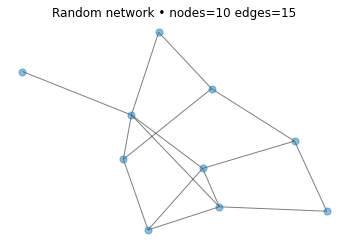

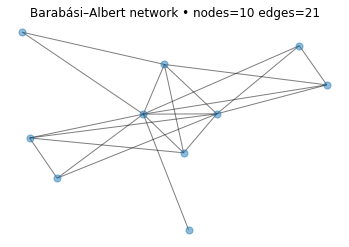

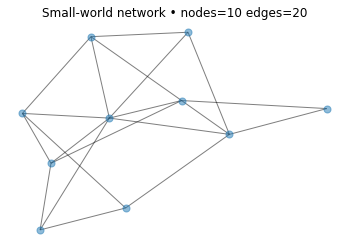

--------------------------------------------------


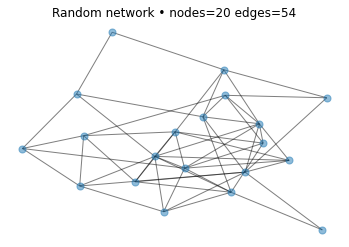

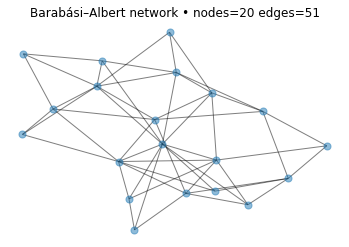

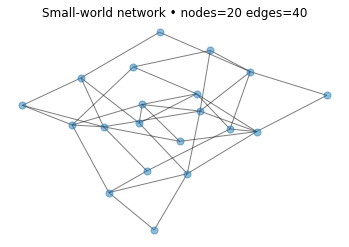

--------------------------------------------------


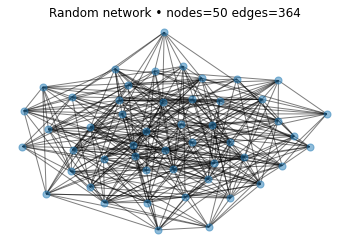

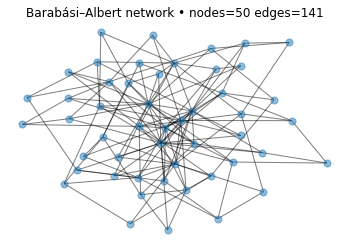

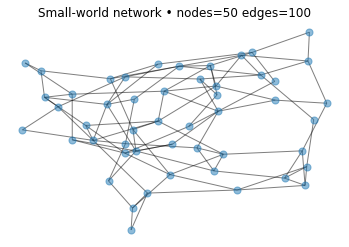

--------------------------------------------------
{'random_n10': <networkx.classes.graph.Graph object at 0x16c000100>, 'barabasi_n10': <networkx.classes.graph.Graph object at 0x16c0a4580>, 'smallworld_n10': <networkx.classes.graph.Graph object at 0x16c17c760>, 'random_n20': <networkx.classes.graph.Graph object at 0x16c1f1a00>, 'barabasi_n20': <networkx.classes.graph.Graph object at 0x16c24a820>, 'smallworld_n20': <networkx.classes.graph.Graph object at 0x16c2a3250>, 'random_n50': <networkx.classes.graph.Graph object at 0x16c2fa430>, 'barabasi_n50': <networkx.classes.graph.Graph object at 0x16c336c70>, 'smallworld_n50': <networkx.classes.graph.Graph object at 0x16c40bc70>}


In [3]:
# save graphs in a dictionary
graphs = {}

for n_nodes in [10,20,50]:
    # random network
    # probability of edge creation
    prob_edge = .3
    g = nx.gnp_random_graph(n_nodes, prob_edge)
    title = "Random network"
    plot_graph_simple(g, title)
    graphs['random_n{}'.format(n_nodes)] = g
    
    # barabasi network
    # Number of edges to attach from a new node to existing nodes
    m_edges = 3
    g = nx.barabasi_albert_graph(n_nodes, m_edges)
    title = "Barabási–Albert network"
    plot_graph_simple(g, title)
    graphs['barabasi_n{}'.format(n_nodes)] = g
    
    # small world network 
    #  n : The number of nodes
    #  k : Each node is connected to k nearest neighbors in ring topology
    #  p : The probability of rewiring each edge
    k = 5
    p = .5
    g = nx.watts_strogatz_graph(n=n_nodes, k=k, p=p)
    title = "Small-world network"
    plot_graph_simple(g, title)
    graphs['smallworld_n{}'.format(n_nodes)] = g
    print("-"*50)
    
print(graphs)

### b.

Use `networkx` to calculate metrics of the three types of networks generated in the previous step, including `nx.density`, `nx.average_shortest_path_length`, `nx.average_degree_connectivity`, `nx.connected_components`. For each metric, read the documentation to see what it means. 
Store the results in a data frame.

In [4]:
net_stats_df = pd.DataFrame()

# loop through dictionary
for gname, g in graphs.items():
    # calculate metrics
    dens = nx.density(g)
    avgsp = None
    diam = None
    # use try/except because for some graphs it is not possible to calculate 
    # these metrics
    try:
        avgsp = round(nx.average_shortest_path_length(g),3)
        diam = nx.diameter(g)
    except NetworkXError as e:
        print(e)
    
    n_comp = len(sorted(nx.connected_components(g), key = len, reverse=True))
    row = pd.DataFrame({'graph_name':gname, 'nodes':len(g), 'edges':len(g.edges()),
                        'diameter':[diam], 'density':[round(dens,3)], 
                        'avg_shortest_path_len':[avgsp], 'n_connected_comp':[n_comp]})
    # add row to data frame
    net_stats_df = net_stats_df.append(row, ignore_index=True)
    
net_stats_df

,graph_name,nodes,edges,diameter,density,avg_shortest_path_len,n_connected_comp
0,random_n10,10,15,3,0.333,1.844,1
1,barabasi_n10,10,21,2,0.467,1.533,1
2,smallworld_n10,10,20,3,0.444,1.600,1
3,random_n20,20,54,4,0.284,1.868,1
4,barabasi_n20,20,51,4,0.268,1.942,1
5,smallworld_n20,20,40,4,0.211,2.121,1
6,random_n50,50,364,3,0.297,1.711,1
7,barabasi_n50,50,141,4,0.115,2.345,1
8,smallworld_n50,50,100,6,0.082,3.055,1


### c.

Researchers have identified a number of [street network types](https://transportgeography.org/contents/chapter8/transportation-urban-form/street_network_types/) that are common in different parts of the world.
Using `osmnx`, retrieve the street network of a small North American city (< 100,000 people) and a city of similar population in Europe and Sub-Saharan Africa. Plot the three networks and inspect them visually.

Trieste, Italy
nodes = 2411
data/streets_city_trieste_it.gpik.gz


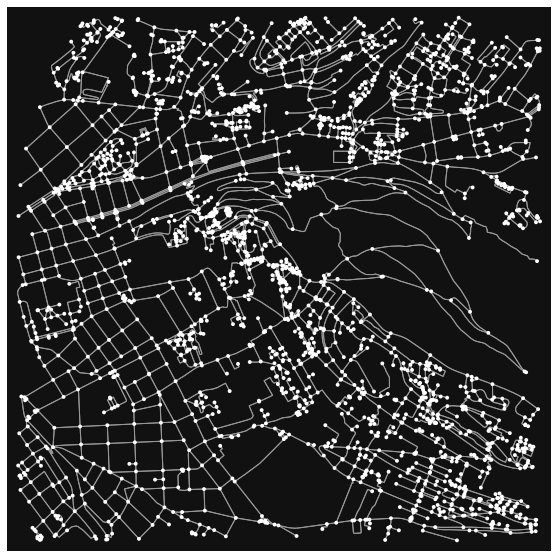

Savannah, Georgia
nodes = 1806
data/streets_city_savannah_ge.gpik.gz


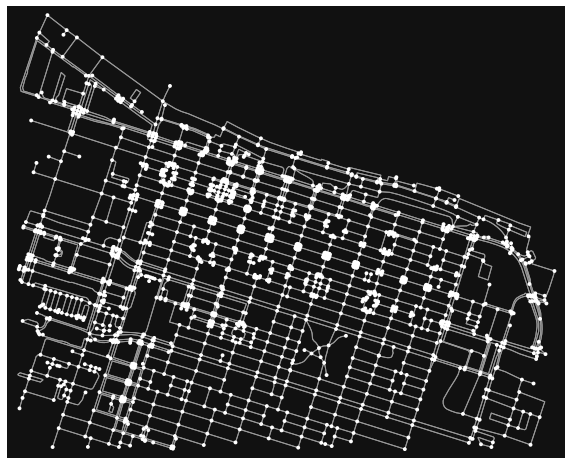

Thika, Kenya
nodes = 306
data/streets_city_thika_ke.gpik.gz


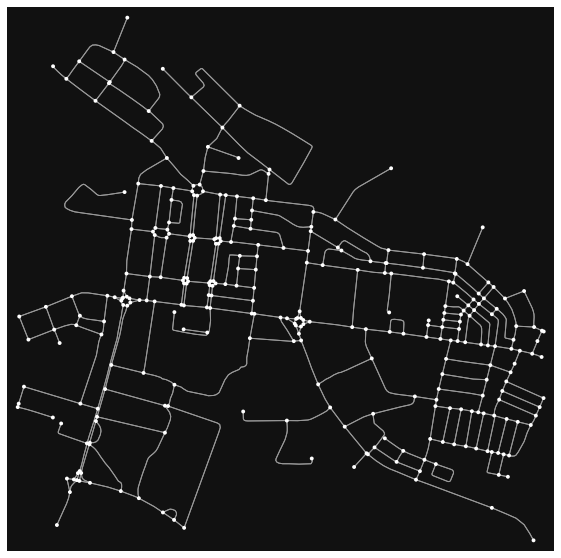

In [5]:
cities = {'trieste_it':'Trieste, Italy',
          'savannah_ge':'Savannah, Georgia',
          'thika_ke':'Thika, Kenya'}

for city_code, city_search in cities.items():
    print(city_search)
    graph = osmnx.graph_from_address(city_search, network_type='walk')
    fout = "data/streets_city_{}.gpik.gz".format(city_code)
    print("nodes =", len(graph))
    print(fout)
    nx.write_gpickle(graph, fout)
    osmnx.plot_graph(graph, figsize=(10,10))

### d.

Compare the three street networks retrieved in the previous exercises and through basic network statistics calculated by the package. Insert the indicators in a data frame to facilitate the comparison. 
Do the indicators vary a lot?

In [6]:
cities_stats_df = pd.DataFrame()

for city_code, city_name in cities.items():
    print("calculate stats for",city_name)
    fn = "data/streets_city_{}.gpik.gz".format(city_code)
    # load graph
    g = nx.read_gpickle(fn)
    
    # project graph to UTM to obtain density information
    g = osmnx.projection.project_graph(g)
    # calculate area in m2
    nodes_proj = osmnx.graph_to_gdfs(g, edges=False)
    graph_area_m2 = nodes_proj.unary_union.convex_hull.area
    print("   graph_area_m2", round(graph_area_m2))
    
    # calculate all stats
    stats_dict = osmnx.stats.basic_stats(g, area=graph_area_m2)
    
    # remove some complex indicators
    del stats_dict['streets_per_node_counts']
    del stats_dict['streets_per_node_proportion']
    # add city name
    stats_dict['city_name'] = city_name
    
    # create row
    row = pd.DataFrame(stats_dict, index=[city_code])
    # add row to results
    cities_stats_df = cities_stats_df.append(row)

# show results
cities_stats_df

calculate stats for Trieste, Italy
   graph_area_m2 3891449
calculate stats for Savannah, Georgia
   graph_area_m2 2310901
calculate stats for Thika, Kenya
   graph_area_m2 2945128


,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km,city_name
trieste_it,2411,6018,4.992119,1732,2.548320,225915.260,37.539924,112957.630,37.539924,3009,619.563589,445.078447,58054.280123,29027.140062,0.000013,0.000997,None,None,"Trieste, Italy"
savannah_ge,1806,5248,5.811739,1399,2.939646,188462.374,35.911276,94231.187,35.911276,2624,781.513348,605.391569,81553.632864,40776.816432,0.000012,0.001524,None,None,"Savannah, Georgia"
thika_ke,306,876,5.725490,288,2.950980,73544.302,83.954683,36772.151,83.954683,438,103.900415,97.788626,24971.514737,12485.757368,0.000014,0.002283,None,None,"Thika, Kenya"


### e.

Origin-Destination (OD) data is used to study flows in transportation networks (see this [introduction](https://cran.r-project.org/web/packages/stplanr/vignettes/stplanr-od.html)).
Using the provided OD data between London bouroughs (Census 2011), create a directed graph with `networkx` with boroughs as nodes and flows as edges.

In [7]:
# download input data
import urllib.request

od_url = "https://github.com/andrea-ballatore/open-geo-data-education/raw/main/datasets/london_travel_origin_destination_2011/greater_london_origin_destination_2011.tsv.gz?raw=true"
od_fname = 'data/london-oa-2011.tsv.gz'
urllib.request.urlretrieve(od_url, od_fname)

('data/london-oa-2011.tsv.gz', <http.client.HTTPMessage at 0x16c17c520>)

In [8]:
# load tsv into a data frame
od_df = pd.read_csv(od_fname, sep='\t')
len(od_df)
od_df.sample(5)

,geo_code1,geo_code2,all,from_home,light_rail,train,bus,taxi,motorbike,car_driver,car_passenger,bicycle,foot,other,geo_name1,geo_name2,la_1,la_2
253740,E02000739,E02000776,1,0,0,0,1,0,0,0,0,0,0,0,Newham 026,Redbridge 026,Newham,Redbridge
168435,E02000494,E02000378,2,0,1,1,0,0,0,0,0,0,0,0,Hillingdon 001,Hammersmith and Fulham 007,Hillingdon,Hammersmith and Fulham
180747,E02000537,E02000369,1,0,1,0,0,0,0,0,0,0,0,0,Hounslow 012,Hackney 025,Hounslow,Hackney
53237,E02000151,E02000209,2,0,0,0,0,0,0,2,0,0,0,0,Bromley 025,Croydon 016,Bromley,Croydon
37229,E02000106,E02000969,11,0,1,0,3,0,0,4,0,0,0,3,Brent 014,Westminster 010,Brent,Westminster


In [9]:
# define re-usable function to plot network layout
def plot_graph(g, title, edge_label_attribute, layout='spring', fig_sz=10):
    """ 
    Function to plot directed graph with appropriate default values. 
    @ g: a graph
    @ title: title of plot
    @ edge_label_attribute: edge attribute name to use as edge labels 
    @ layout: network layout to use
    @ fig_sz: size of canvas
    """
    # generate positions of nodes based on selected layout
    if layout=='spring':
        pos = nx.spring_layout(g, k=0.55, iterations=30)
    elif layout=='circular':
        pos = nx.circular_layout(g)
    else:
        raise Error("Invalid layout")
    
    # set figure up
    plt.figure(figsize=(fig_sz, fig_sz))
    # open drawing
    nx.draw_networkx(g, pos=pos, node_color='lightblue', alpha=.8)
    if edge_label_attribute:
        # extract edge labels
        edge_labels = nx.get_edge_attributes(g,edge_label_attribute)
        # draw edge labels
        nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, alpha=.6)
    # draw edges
    nx.draw_networkx_edges(g, pos=pos, arrows=True, alpha=.6, edge_color='lightgray')
    plt.title(title)
    plt.show()

In [10]:
# aggregate OD counts by boroughs
borough_od = od_df.groupby(["la_1", "la_2"])[['all','train','bus','car_driver','bicycle']].sum().reset_index()
# see data for flows from all boroughs to the City
borough_od[borough_od.la_2=='City of London'].sort_values('all',ascending=False)

,la_1,la_2,all,train,bus,car_driver,bicycle
1126,Wandsworth,City of London,16956,5240,702,365,1566
1058,Tower Hamlets,City of London,15035,582,1999,204,1055
990,Southwark,City of London,13274,2491,3390,236,1195
1160,Westminster,City of London,12667,254,550,406,627
785,Lambeth,City of London,12661,2387,1673,195,1355
685,Islington,City of London,11698,677,3264,180,1240
718,Kensington and Chelsea,City of London,10543,187,164,572,339
143,Bromley,City of London,9951,8930,112,347,151
178,Camden,City of London,9856,1075,602,272,643
480,Hammersmith and Fulham,City of London,8408,213,156,204,604


In [11]:
# see data for flows from City to all other boroughs
borough_od[borough_od.la_1=='City of London'].sort_values('all',ascending=False)

,la_1,la_2,all,train,bus,car_driver,bicycle
213,City of London,City of London,1506,41,32,8,33
239,City of London,Westminster,503,9,57,10,48
212,City of London,Camden,347,17,49,6,26
225,City of London,Islington,336,8,24,7,22
236,City of London,Tower Hamlets,306,3,21,13,37
234,City of London,Southwark,164,7,25,3,19
218,City of London,Hackney,129,6,17,7,15
219,City of London,Hammersmith and Fulham,58,1,1,2,1
226,City of London,Kensington and Chelsea,51,4,2,2,2
228,City of London,Lambeth,47,1,11,2,7


In [12]:
# sums of flows boroughs (origin): sum of flows starting from a borough
borough_sum_od = od_df.groupby(["la_1"])[['all']].sum().reset_index()
borough_sum_od.sort_values('all',ascending=False)
# this matches the intuition that many people leave peripheral 
# residential boroughs to go to work elsewhere

,la_1,all
33,Wandsworth,139344
23,Lambeth,130207
7,Croydon,123646
8,Ealing,119110
1,Barnet,117662
29,Southwark,115644
4,Bromley,110584
3,Brent,106170
24,Lewisham,105395
10,Enfield,99080


In [13]:
# sums of flows boroughs (destination): sum of flows towards a borough
borough_sum_od = od_df.groupby(["la_2"])[['all']].sum().reset_index()
borough_sum_od.sort_values('all',ascending=False)
# this matches the intuition that central boroughs with offices and 
# commercial areas attract flows of commuters

,la_2,all
34,Westminster,431731
6,City of London,244502
5,Camden,199038
31,Tower Hamlets,165584
29,Southwark,125911
20,Islington,118922
23,Lambeth,91157
18,Hillingdon,90880
14,Hammersmith and Fulham,90550
21,Kensington and Chelsea,85782


In [14]:
print(borough_od.columns)

# add inverted_all. This is useful for the centrality metrics, 
# as we want to interpret the intensity of flows as a positive aspect 
# (higher flow = low weight)
borough_od['inverted_all'] = -borough_od['all'] 
borough_od.sample(5)

Index(['la_1', 'la_2', 'all', 'train', 'bus', 'car_driver', 'bicycle'], dtype='object')


,la_1,la_2,all,train,bus,car_driver,bicycle,inverted_all
635,Hillingdon,Newham,168,12,15,64,0,-168
565,Harrow,Merton,124,22,3,26,2,-124
25,Barking and Dagenham,Newham,4829,545,883,2231,74,-4829
670,Hounslow,Newham,220,41,16,49,5,-220
502,Hammersmith and Fulham,Sutton,102,41,5,39,1,-102


In [15]:
# build networkx graph as directed graph (DiGraph)
od_g = nx.from_pandas_edgelist(borough_od, source='la_1', target='la_2', 
                edge_attr=['all', 'inverted_all', 'train', 'bus', 'car_driver', 'bicycle'], 
                create_using=nx.DiGraph)
print("graph loaded n={} m={}".format(len(od_g), len(od_g.edges)))

graph loaded n=35 m=1188


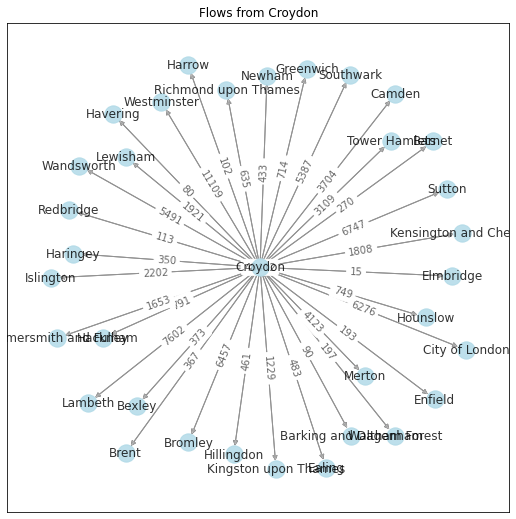

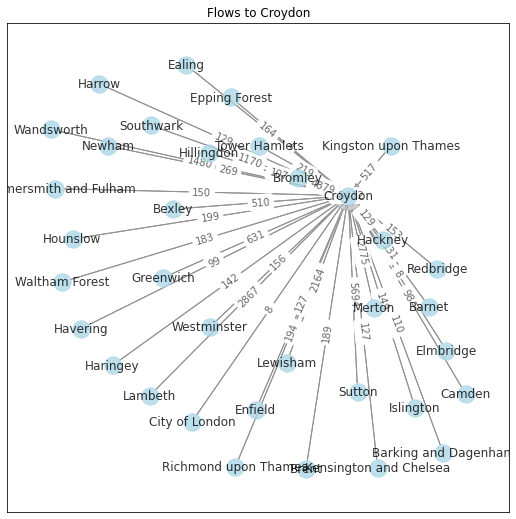

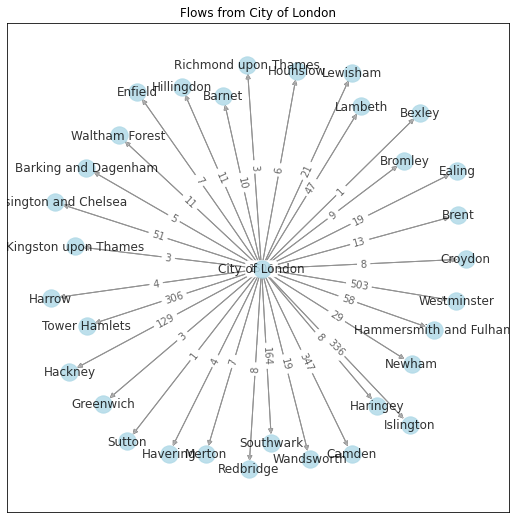

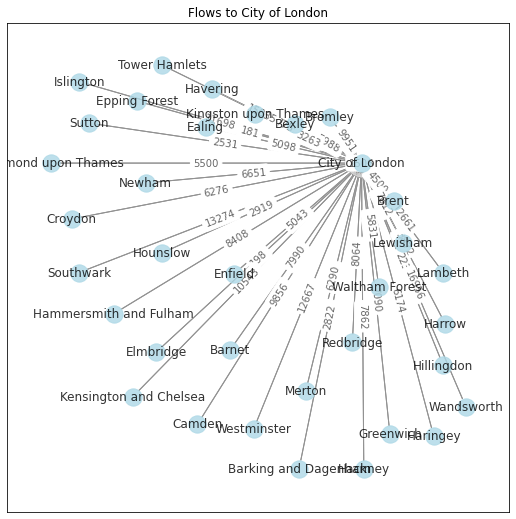

In [16]:
# plot subgraph to verify that the data is correct
for boro in ['Croydon','City of London']:
    # extract sub graph for a borough
    # out edges
    edges = od_g.out_edges(boro, data=True)
    g = nx.DiGraph(edges)
    plot_graph(g, "Flows from "+boro, 'all', fig_sz=9)
    # in edges
    edges = od_g.in_edges(boro, data=True)
    g = nx.DiGraph(edges)
    plot_graph(g, "Flows to "+boro, 'all', fig_sz=9)

### f.

Calculate the betweeness centrality of boroughs in the OD data using a weighted metric (using the values in `all` as weights). Note that an unweighted analysis would not be meaningful as all boroughs are connected to all other boroughs.

This analysis should reveal to what extent a borough is central to the mobility patterns in Greater London. 
Note that, depending on whether the weight represents either a _cost_ (higher=worse) or an _opportunity_ (higher=better), the values can be inverted using `1/weight`. Experiment with `all` and `inverted_all` to see how the results change.

In [17]:
var = 'inverted_all'
print("calculate betweenness centrality based on flow attribute:",var)
# calculate betweenness centrality based on density of nodes
boro_centrality = nx.algorithms.centrality.betweenness_centrality(od_g, weight=var)
# convert the data to a data frame
col_name = "betw_centrality_"+var
boro_centrality_df = pd.DataFrame.from_dict(boro_centrality, 
                                orient='index', columns=[col_name])
# round scores
boro_centrality_df[col_name] = boro_centrality_df[col_name].round(5)
# sort and save results
boro_centrality_df = boro_centrality_df.sort_values(col_name, ascending=False)
boro_centrality_df.to_csv('tmp/orig_dest_flows_boroughs_{}.csv'.format(var), index=True, index_label='borough_name')
print(boro_centrality_df)

calculate betweenness centrality based on flow attribute: inverted_all
                        betw_centrality_inverted_all
Westminster                                  0.98485
City of London                               0.96435
Camden                                       0.93048
Islington                                    0.90107
Tower Hamlets                                0.88057
Hackney                                      0.84403
Southwark                                    0.81462
Lambeth                                      0.77362
Wandsworth                                   0.74332
Hammersmith and Fulham                       0.71301
Kensington and Chelsea                       0.68538
Hounslow                                     0.65954
Hillingdon                                   0.64617
Ealing                                       0.63280
Brent                                        0.55348
Barnet                                       0.50446
Enfield                     

### g.

Using the London OD data, generate a plot using the circular layout. Make the thickness of edges proportional to the number of trips (column `all`). As the plot is likely to be too dense, try to prune the network by keeping only edges with `all` above a certain threshold.

In [18]:
print(borough_od['all'].describe())
# get heavier edges, with 'all' value above threshold
min_threshold = 6000
high_od = borough_od[borough_od['all'] >= min_threshold]
# generate the graph from the pandas df
high_od_g = nx.from_pandas_edgelist(high_od, source='la_1', target='la_2', 
                edge_attr=['all', 'inverted_all', 'train', 'bus', 'car_driver', 'bicycle'], 
                create_using=nx.DiGraph)

print("edges =",len(high_od_g.edges))

count     1188.000000
mean      2464.122054
std       5205.867007
min          1.000000
25%        123.750000
50%        460.500000
75%       2288.000000
max      48412.000000
Name: all, dtype: float64
edges = 136


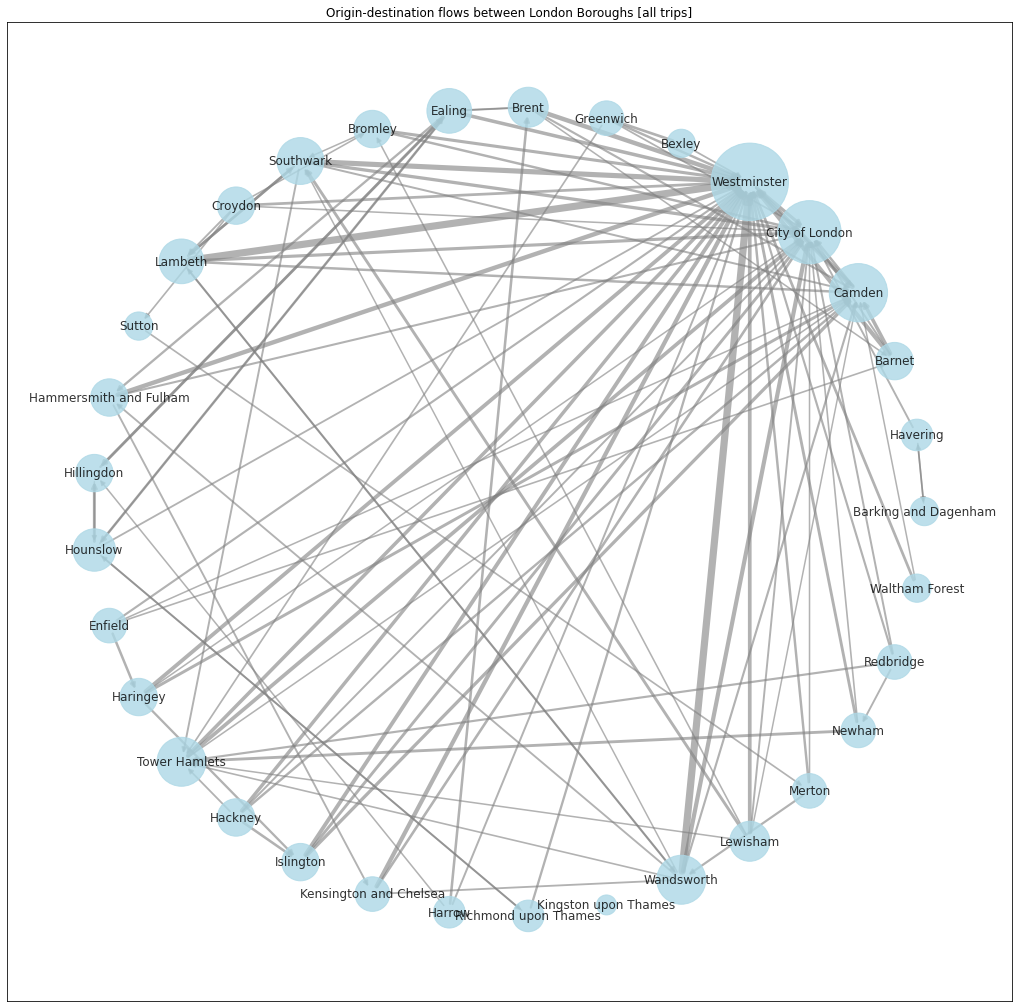

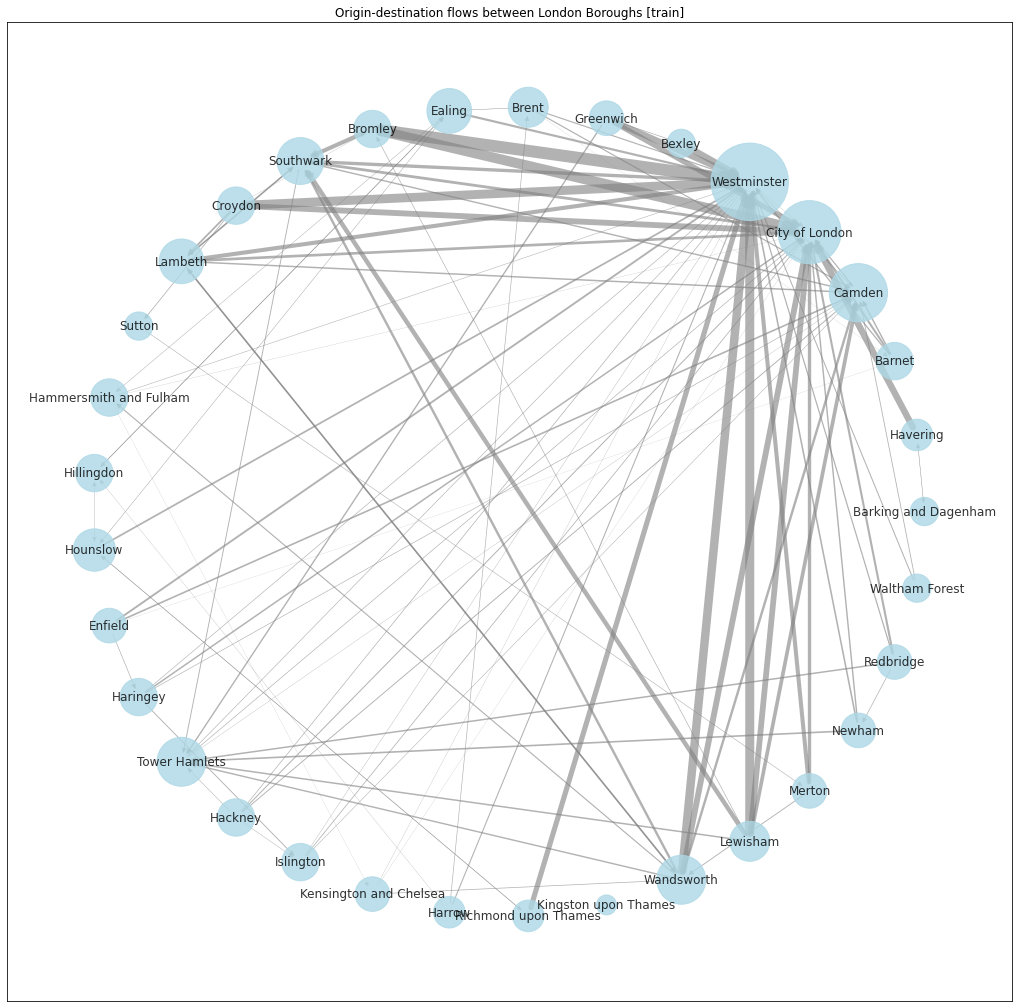

In [19]:
def plot_flow_graph(g, title, edge_weight_attribute, fig_sz=10, use_node_position=False):
    """ 
    Plot a networkx graph with variable node size and edge width
    @node_pos: position of nodes
    """
    # set figure up
    plt.figure(figsize=(fig_sz, fig_sz))

    edges = g.edges()
    
    if not use_node_position:
        pos = nx.circular_layout(g)
    else:
        pos = nx.get_node_attributes(g, 'pos')
        
    # calculate node sizes based on node degree (higher degree -> bigger node)
    node_sizes = [deg*200 for n, deg in nx.degree(g)]
    # draw nodes
    nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color='lightblue', alpha=.8)
    nx.draw_networkx_labels(g, pos, font_size=12, alpha=.8)
    
    # calculate edge widths
    edge_widths = list(nx.get_edge_attributes(g, edge_weight_attribute).values())
    edge_widths = [w/max(edge_widths)*12 for w in edge_widths]
    # calculate edges
    nx.draw_networkx_edges(g, pos=pos, width=edge_widths, arrows=True, alpha=.6, edge_color='gray')
    plt.title(title)
    plt.show()

plot_flow_graph(high_od_g, 'Origin-destination flows between London Boroughs [all trips]', 'all', fig_sz=18)
plot_flow_graph(high_od_g, 'Origin-destination flows between London Boroughs [train]', 'train', fig_sz=18)

In [20]:
# get centroids of boroughs

url = "https://github.com/andrea-ballatore/open-geo-data-education/raw/main/datasets/london_borough_profiles_2015/london_boroughs_profiles_2015.geojson?raw=true"
fname = 'data/london-boroughs-2015.geojson'
urllib.request.urlretrieve(url, fname)

('data/london-boroughs-2015.geojson', <http.client.HTTPMessage at 0x16cc60640>)

<AxesSubplot:>

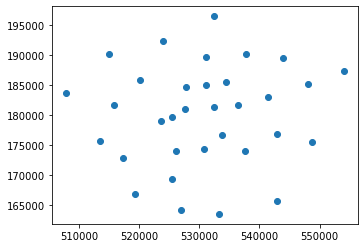

In [21]:
boro_gdf = geopandas.read_file(fname)[['gss','name','geometry']]
boro_gdf['centroid'] = boro_gdf.to_crs(27700).centroid
# centroids of boroughs in British National Grid coordinates
boro_gdf['centroid'].plot()

In [22]:
# apply positions to nodes
# there is perfect overlap between node names and borough names: 
# the data can be merged
print("Mismatching boroughs:", set(high_od_g.nodes).symmetric_difference(set(boro_gdf.name)))

Mismatching boroughs: set()


In [23]:
# get centroid x,y coordinates
pos_dict = {}
for idx, row in boro_gdf.iterrows():
    pos_dict[row['name']]=[row['centroid'].x,row['centroid'].y]

print(pos_dict)
# set positions to the nodes
nx.set_node_attributes(high_od_g, pos_dict, "pos")

{'Kingston upon Thames': [519296.0184151281, 166820.05669606803], 'Croydon': [533288.3290521045, 163541.31241937066], 'Bromley': [542893.66057169, 165655.5151342308], 'Hounslow': [513513.98536191543, 175643.13971047456], 'Ealing': [515886.4167066859, 181715.3523340073], 'Havering': [554047.126343339, 187391.7675751669], 'Hillingdon': [507888.3112502047, 183652.62635745513], 'Harrow': [514985.17188387556, 190066.53359575037], 'Brent': [520176.2309179021, 185829.24839474942], 'Barnet': [524025.89925981284, 192315.96352236805], 'Lambeth': [530842.950674781, 174356.32049001718], 'Southwark': [533818.8154161617, 176665.6745990482], 'Lewisham': [537668.6465864129, 173980.6908797493], 'Greenwich': [542906.2528846019, 176875.6461142014], 'Bexley': [548792.5597236288, 175487.08696452645], 'Enfield': [532422.1923218234, 196420.50966045333], 'Waltham Forest': [537756.3395932297, 190223.17866411124], 'Redbridge': [543913.1003323202, 189464.7905850453], 'Sutton': [526975.1354893161, 164133.99821821

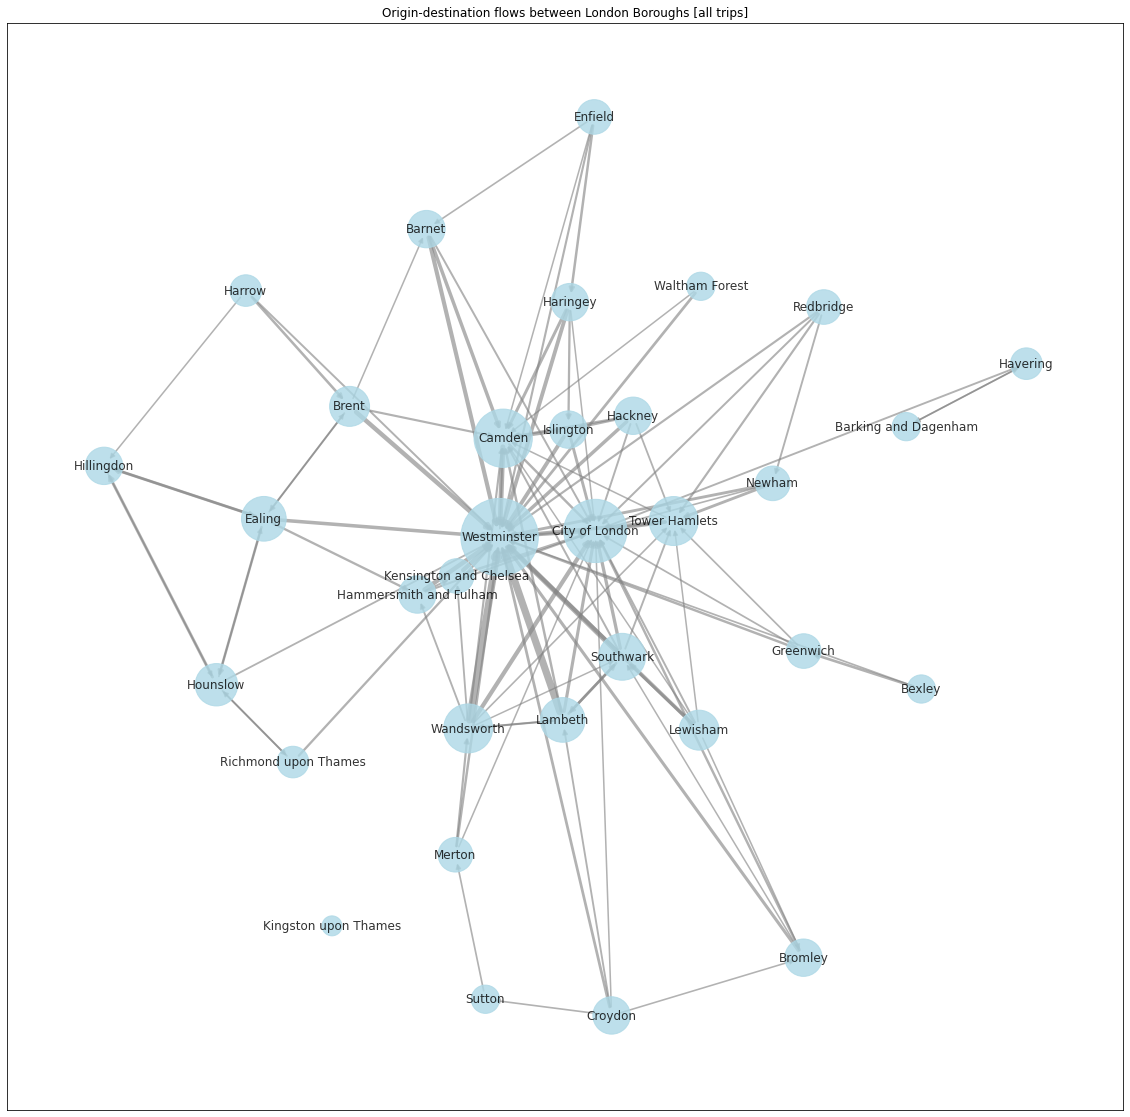

In [24]:
# plot flow graph with geolocations as node positions
plot_flow_graph(high_od_g, 'Origin-destination flows between London Boroughs [all trips]', 
                'all', use_node_position=True, fig_sz=20)

### h.

Transport systems can be intuitively represented as networks. The London Underground network is one of the most famous in the world and can be loaded in `networkx` this way
[(Mark Dunne, 2016)](http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/):

In [25]:
# load tube input data: edge list 
connections = pd.read_csv('data/london_tube_2015/london_tube_connections.csv')
# node list
stations = pd.read_csv('data/london_tube_2015/london_tube_stations.csv')

# create undirected graph (we assume that a->b is the same as b->a)
g = nx.Graph()

# scan connections and creates nodes and edges
for connection_id, connection in connections.iterrows():
    # get rows with station attributes as dictionaries
    station1 = stations[stations.id == connection['station1']].to_dict('records')[0]
    station2 = stations[stations.id == connection['station2']].to_dict('records')[0]
    # add stations with the attributes
    g.add_node(station1['id'])
    nx.set_node_attributes(g, {station1['id']: station1})
    g.add_node(station2['id'])
    nx.set_node_attributes(g, {station2['id']: station2})
    
    # add connection between stations with their attributes
    g.add_edge(station1['id'], station2['id'], time_min = connection['time'], line_id = connection['line'])

# check and save results in two formats
nx.info(g)
tube_file1 = 'tmp/london_tube_network_2015.graphml'
tube_file2 = 'tmp/london_tube_network_2015.gexf'
nx.write_graphml(g, tube_file1)
nx.write_gexf(g, tube_file2)
print("graph saved in",tube_file1,"and",tube_file2)

graph saved in tmp/london_tube_network_2015.graphml and tmp/london_tube_network_2015.gexf


Using network analysis concepts on the Tube network:
- Calculate basic network metrics of the tube. 
- Calculate at least two measures of centrality of the stations using the `time_min` (travel time in minutes) attribute as weights. 
- Try to plot the network changing the colour of nodes based on centrality. 
- Try to identify "communities" of stations that are highly interconnected.

Name: 
Type: Graph
Number of nodes: 302
Number of edges: 349
Average degree:   2.3113


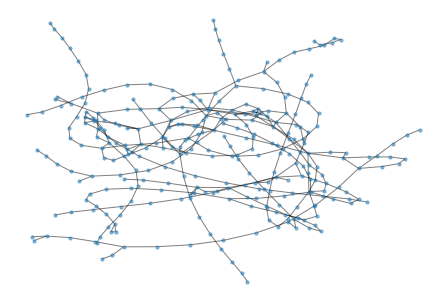

In [26]:
tube_g = nx.read_graphml(tube_file1)
print(nx.info(tube_g))
# plot network a-spatially (not using geolocations)
nx.draw(tube_g, node_size=10, alpha=.5)

In [30]:
# calculate network metrics
print("average_shortest_path_length =", round(nx.average_shortest_path_length(tube_g),2))
nx.set_node_attributes(tube_g, nx.algorithms.centrality.betweenness_centrality(tube_g, weight='time_min'), "betw_centrality")
nx.set_node_attributes(tube_g, nx.algorithms.centrality.degree_centrality(tube_g), "degree_centrality")

average_shortest_path_length = 14.1


In [32]:
# build lists for data frame
degrees = [val for (node, val) in tube_g.degree()]
# this is a way to get the values of an attribute in a graph (in this case 'name')
names = [tube_g.nodes[node]['name'] for node in tube_g]
bcentral = [round(tube_g.nodes[node]['betw_centrality'],5) for node in tube_g]
degree_centrality = [round(tube_g.nodes[node]['degree_centrality'],5) for node in tube_g]

# assemble lists into a data frame
net_stats_df = pd.DataFrame({'name':names, 'degree': degrees, 'betw_centrality':bcentral, 'degree_centrality':degree_centrality})

# save and show results
net_stats_df = net_stats_df.sort_values('betw_centrality', ascending=False)
net_stats_df.to_csv('tmp/london_tube_network_stats.csv', index=False)
net_stats_df

,name,degree,betw_centrality,degree_centrality
33,Bond Street,4,0.29845,0.01329
25,Bank,6,0.28203,0.01993
0,Baker Street,7,0.28119,0.02326
24,Oxford Circus,6,0.27358,0.01993
93,Victoria,4,0.22257,0.01329
...,...,...,...,...
171,New Cross Gate,1,0.00000,0.00332
115,Kensington (Olympia),1,0.00000,0.00332
108,Chiswick Park,2,0.00000,0.00664
173,Shoreditch,1,0.00000,0.00332


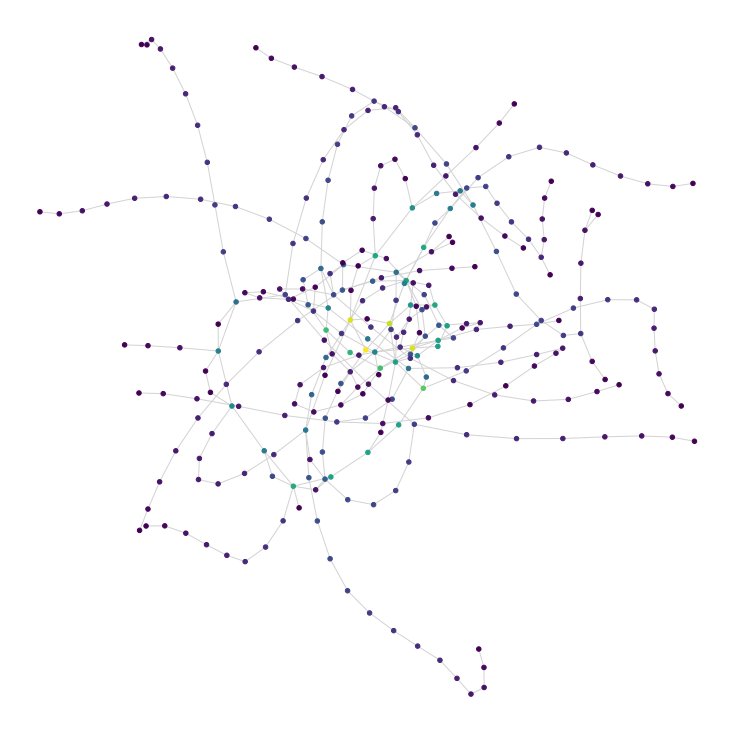

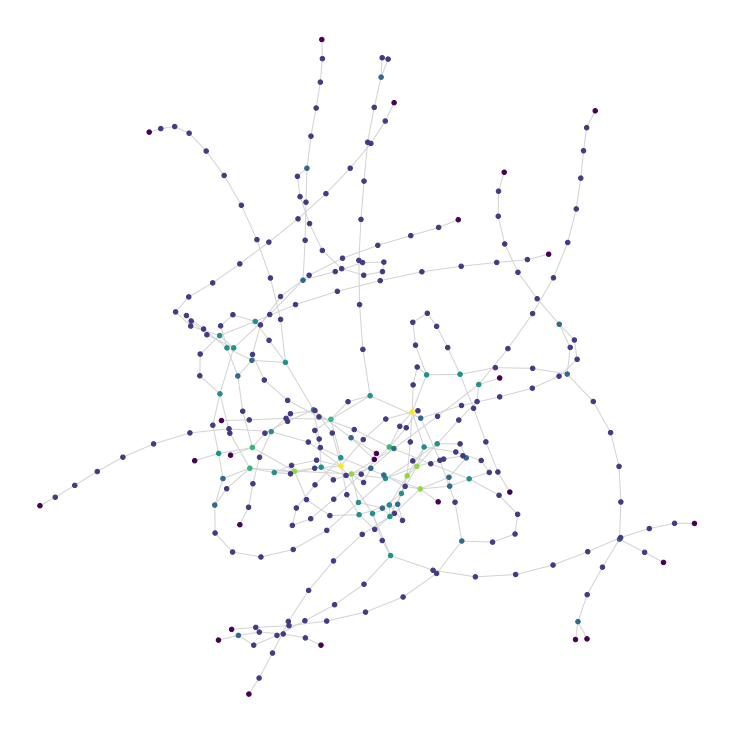

In [28]:
def plot_graph_color_nodes(g, colour_attr):
    """ Plot graph changing the node colours based on @colour_attr """
    fig_sz = 10
    plt.figure(figsize=(fig_sz, fig_sz))
    # generate sequence of colors based on attribute
    # note: g.nodes[node][colour_attr] access attribute <colour_attr> in node with id <node>
    bcentral = [g.nodes[node][colour_attr] for node in tube_g]
    colors = [i/max(bcentral) for i in bcentral]
    # draw graph with colour sequence
    nx.draw_spring(g, node_size=20, node_color=colors, edge_color='lightgray')
    
plot_graph_color_nodes(tube_g, 'betw_centrality')
plot_graph_color_nodes(tube_g, 'degree_centrality')

In [33]:
# find communities of interconnected stations
# using greedy modularity
from networkx import community

def find_communities(g):
    """ 
    Detect communities using greedy modularity
    @ returns a dictionary with detected communities and their nodes.
    """
    communities = community.greedy_modularity_communities(g)
    res = {}
    for i, comm in enumerate(communities):
        res[i] = [c for c in comm]
    return res

In [34]:
# find communities
comms = find_communities(tube_g)
# print results
for comm_id, comm_members in comms.items():
    print('\nGroup',comm_id)
    station_names = [tube_g.nodes[memb]['name'] for memb in comm_members]
    station_names = sorted(station_names)
    
    print(' • '.join(station_names))


Group 0
All Saints • Bermondsey • Bethnal Green • Blackwall • Bow Church • Bow Road • Bromley-By-Bow • Canada Water • Canary Wharf • Canning Town • Devons Road • East India • Limehouse • Mile End • New Cross • New Cross Gate • North Greenwich • Poplar • Pudding Mill Lane • Rotherhithe • Shadwell • Shoreditch • Stepney Green • Stratford • Surrey Quays • Tower Gateway • Wapping • West Ham • West India Quay • Westferry • Whitechapel

Group 1
Aldgate • Aldgate East • Bank • Blackfriars • Borough • Brixton • Cannon Street • Chancery Lane • Elephant & Castle • Embankment • Kennington • Lambeth North • Liverpool Street • London Bridge • Mansion House • Monument • Oval • Pimlico • Southwark • St. James's Park • St. Paul's • Stockwell • Temple • Tower Hill • Vauxhall • Victoria • Waterloo • Westminster

Group 2
Baker Street • Bayswater • Bond Street • Charing Cross • Covent Garden • Edgware Road (B) • Edgware Road (C) • Finchley Road • Goodge Street • Green Park • Holborn • Lancaster Gate • Le

___ 

End of notebook